In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Select region of interest from an image using FFTs

This example shows how to crop an image using `nanomesh` using the characteristics of an FFT to select a bbox matching the lattice of the crystal.

In [2]:
from nanomesh import Volume, Plane
vol = Volume.load('sample_data.npy')
plane = vol.select_plane(x=161)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


This operation takes the fft of the image, and creates a regular array of the recurring components. The distance between the peaks in the image correspond to the distance between the pores in the source image.

<IPython.core.display.Javascript object>


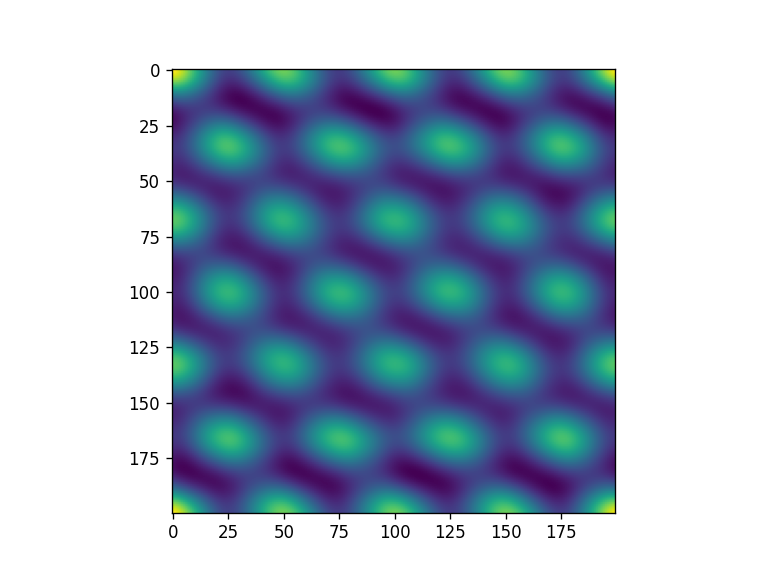

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def abs2(x):
    return x.real**2 + x.imag**2

fft = np.fft.fft2(plane.image)
ifft = np.fft.ifft2(abs2(fft))

filtered = abs(ifft)

plt.figure()
plt.imshow(filtered)
plt.show()

### Peak-finding

Use a Difference of Gaussian to find the peaks in the image.

<IPython.core.display.Javascript object>


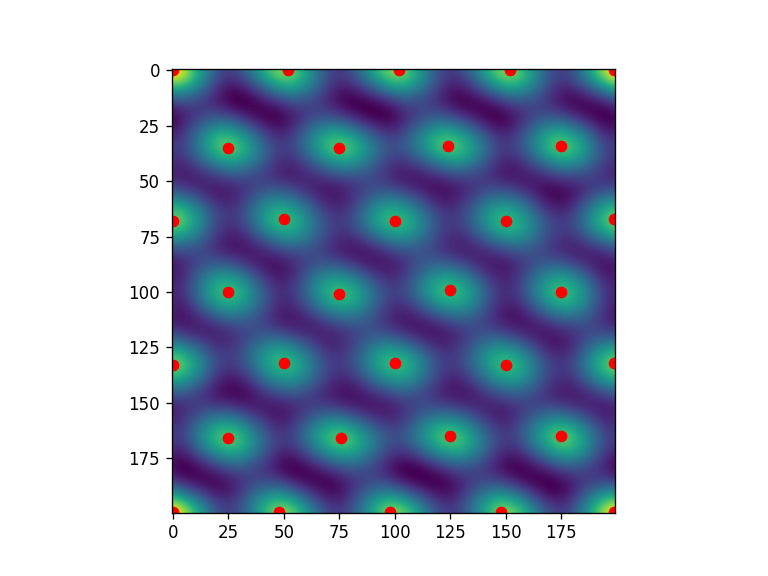

In [4]:
from skimage import feature

peaks = feature.blob_dog(filtered, min_sigma=10, max_sigma=20, overlap=1, threshold=5)
peaks = peaks[:,0:2]
x, y = peaks.T

plt.figure()
plt.imshow(filtered)
plt.scatter(y, x, color='red')
plt.show()

### ROI picking

A Delauney triangulation is used to create a mesh out of the peaks. The mesh is subdivided once to create additional granularity for the point picking in the roi selection.

In [5]:
from scipy.spatial import Delaunay
tris = Delaunay(peaks)

from nanomesh.mesh_container import TriangleMesh

triangles = TriangleMesh.from_scipy(tris)
triangles = triangles.subdivide()

The vertices are passed to the `.select_roi` method to pick from.

- By passing `from_points`, vertices snap to the nearest point (use 'ctrl' to drag it away)
- Press the 'esc' key to start a new polygon
- Hold the 'shift' key to move all of the vertices
- Hold the 'ctrl' key to move a single vertex

<IPython.core.display.Javascript object>


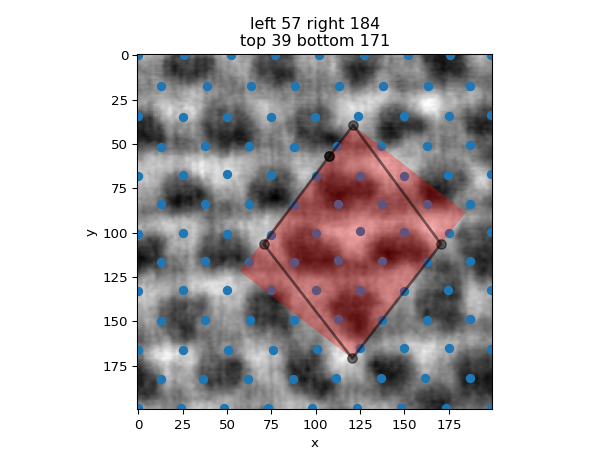

In [7]:
roi = plane.select_roi(from_points=triangles.points)

The `.bbox` attribute is updated when the selection above changes.

In [8]:
roi.bbox

array([[184.47897538,  88.43932955],
       [121.11688312,  39.32142857],
       [ 57.25479085, 121.70352759],
       [120.61688312, 170.82142857]])

Use the `.crop_to_roi` method to extract the region of interest.

<IPython.core.display.Javascript object>


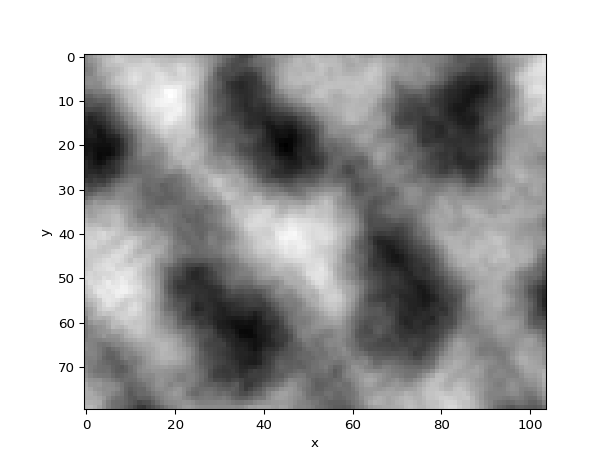

<AxesSubplot:xlabel='x', ylabel='y'>

In [9]:
plane_roi = plane.crop_to_roi(bbox=roi.bbox)
plane_roi.show()